In [1]:
import argparse
import os
import random
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.pyplot import imshow, imsave


In [ ]:
# This cell is only for Google Colaboratory
#from google.colab import drive
#drive.mount('/content/gdrive')

# Defining parameters

In [2]:
# Number of workers for dataloader, had problems using colab so this varied from 2 to 10 when training there.
workers = 2

# Batch size during training
batch_size = 50

# Size of the images, they are already this size as we did preprocess them separately.
image_size = 64

# Number of channels in the training images. 1 for MNIST, 3 for color images.
nc = 3 

# Minimum size of feature maps/channels in generator.
ngf = 32

# Minimum size of feature maps/channels in discriminator.
ndf = 32

# Number of training epochs
num_epochs = 1000

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of labels CIFAR10 and MNIST has 10, we used varying number for dataset (implementation worked with 4 at most)
num_labels = 3

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


Files already downloaded and verified


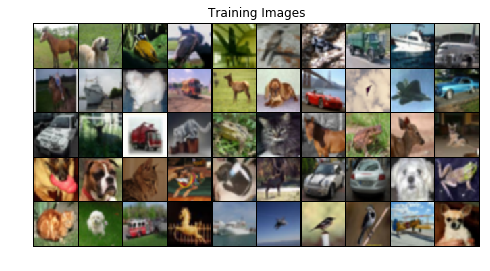

In [3]:
## Downloading datasets from torchvision (MNIST/CIFAR10)
transform=torchvision.transforms.Compose([
                                 torchvision.transforms.Resize(image_size),
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize(
                                 (0.5,0.5,0.5), (0.5,0.5,0.5))])

dataset =  torchvision.datasets.CIFAR10('/files/', train=True, download=True, transform = transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(DEVICE),nrow = 10, padding=2, normalize=True).cpu(),(1,2,0)))

Number of images in the dataset:  18003


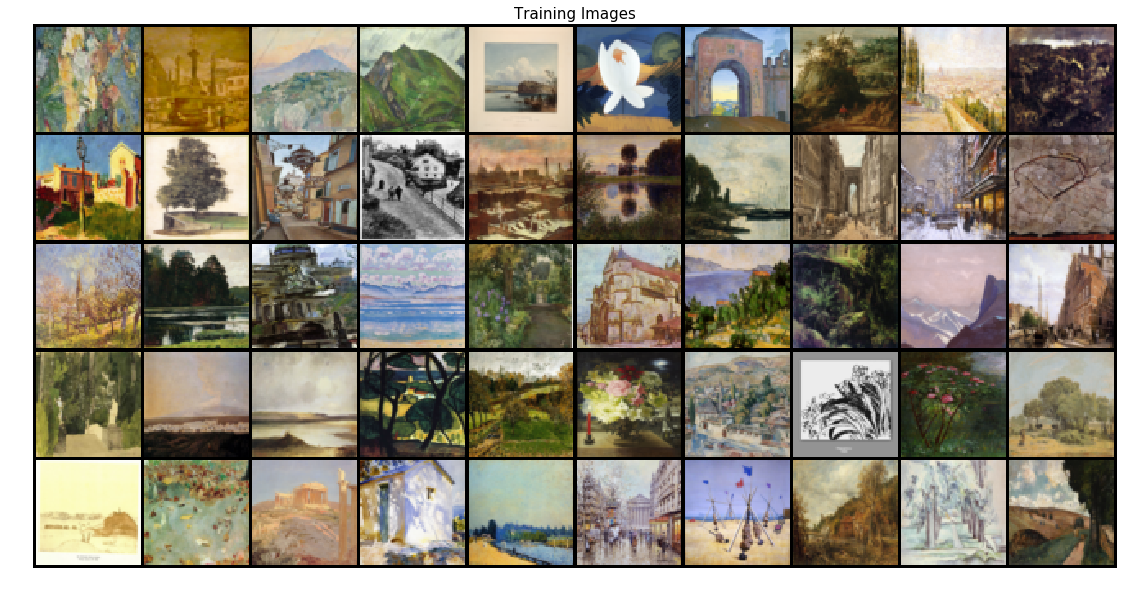

In [4]:
# Downloading our custom dataset

dataset = []
# Loop through a folder that has subfolders with names: Label1, Label2 ...
for i in range(1,num_labels + 1):
    dataset.append(dset.ImageFolder(root=F"../resized_images/Label{i}",
                           transform=transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])))

      
# Create labels for our dataset
# Labels are in i
for i in range(len(dataset)):
    for j in range(len(dataset[i])):
        dataset[i].samples[j] = (dataset[i].samples[j][0],i)
        
# Combine the datasets and create a dataloader
newdataset = torch.utils.data.ConcatDataset(dataset)
dataloader = torch.utils.data.DataLoader(newdataset, batch_size=batch_size,
                                        shuffle=True, num_workers=workers)


# Plot some training images
real_batch,labels = next(iter(dataloader))
plt.figure(figsize=(25,10))
plt.axis("off")
plt.title("Training Images",FontSize=15)
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(DEVICE), padding=2, nrow = 10, normalize=True).cpu(),(1,2,0)))

# Number of images has to be divisible with the batch size.
print("Number of images in the dataset: ",len(dataloader.dataset))

In [5]:
# Initializer for weights of convolutional layers. 
def normal_init(m, mean=0., std=0.02):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d): 
        m.weight.data.normal_(mean, std)
 

In [6]:
class Discriminator(nn.Module):
    """
        5 Convolutionla layers, number of channels/feature maps is doubled after each layer
        1 Dense layer for real/fake predictions and 
        1 Dense layer for class predictions
        => 2 outputs
        
    """
    def __init__(self, num_classes=10, nc=3, ndf = 16,batch_size = 100):
        super(Discriminator, self).__init__()
        
        self.ndf = ndf
        self.batch = batch_size
        
        # Layers
        self.conv1 = nn.Conv2d(nc, ndf ,5, 2, 2, bias=False)
        #self.bn1 = nn.BatchNorm2d(ndf) # No batchnorm for first layer in discriminator
        
        self.conv2 = nn.Conv2d(ndf,ndf * 2, 5, 2, 2, bias = False)
        self.bn2 = nn.BatchNorm2d(ndf * 2)
        
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 5, 2, 2, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 4)
        
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 5, 2, 2, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf * 8)

        self.conv5 = nn.Conv2d(ndf * 8, ndf * 16, 5, 2, 2, bias=False)
        self.bn5 = nn.BatchNorm2d(ndf * 16)
        
        self.LinAux = nn.Linear(16*ndf*2*2, num_classes)
        self.LinD = nn.Linear(16*ndf*2*2, 1)
        
        # Activation funcs and weight init
        self.act = nn.LeakyReLU(0.2,inplace=True)
        self.out1 = nn.Sigmoid()
        self.out2 = nn.LogSoftmax(dim=1)
        self.weight_init(mean = 0., std = 0.02)
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    
    def forward(self, x):
        
        #3x64x64 --> 32x32x32
        x = self.act(self.conv1(x))
        #32x32x32 --> 64x16x16
        x = self.act(self.bn2(self.conv2(x)))
        #64x16x16 --> 128x8x8
        x = self.act(self.bn3(self.conv3(x)))
        #128x8x8 --> 256x4x4
        x = self.act(self.bn4(self.conv4(x)))
        #256x4x4 --> 512x2x2
        x = self.act(self.bn5(self.conv5(x)))
        #512x2x2 --> 1 x flatted (e.g. 1x2048)
        x = x.view(self.batch,-1)
        # 1x2048 --> 1x10
        x_ax = self.LinAux(x)
        # 1x2048 --> 1x1
        x_d = self.LinD(x)
        
        return self.out1(x_d),self.out2(x_ax)

In [7]:
#Testing Disc dimensions:
inp_tensor = real_batch
print('Input:',inp_tensor.shape)
#labels = real_batch[1]
#print(labels.shape)
#onehot = torch.zeros(num_labels, num_labels)
#onehot = onehot.scatter_(1, torch.LongTensor([range(num_labels)]).view(num_labels,1), 1).view(num_labels, num_labels, 1, 1)
#y_label = onehot[labels]
#print('onehot:',y_label[0],'\nlabel: ',labels[0],'\n')


D = Discriminator(batch_size=batch_size)
print(D)
predictions_real, predictions_labels = D(inp_tensor)

print('\nNumber of Trainable parameters:',sum(p.numel() for p in D.parameters() if p.requires_grad))

Input: torch.Size([50, 3, 64, 64])
Discriminator(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LinAux): Linear(in_features=1024, out_features=10, bias=True)
  (LinD): Linear(in_features=1024, out_features=1, bias=True)
  (act): LeakyReLU

In [8]:
class Generator(nn.Module):
    """
        ACGAN Generator
        1 Dense Layer
        Batchnorm after dense layer
        5  Transposed Convolutional layers
        Batchnorms after conv layers
        LeakyRelus as activation func.
        Tanh as output
    """
    def __init__(self, input_size = 100, num_classes=10,ngf = 16,batch_size=batch_size):
        super(Generator, self).__init__()

        self.n_classes = num_classes
        self.b_size = batch_size
        # No bias, ok results
        self.Lin1 = nn.Linear(input_size + num_classes, ngf * 32, bias = False)
        
        self.conv1 = nn.ConvTranspose2d(ngf*32, ngf*16, 4, 1, 0,bias=False)
        self.bn1 = nn.BatchNorm2d(ngf*16)
        
        
        self.conv2 = nn.ConvTranspose2d(ngf * 16,ngf * 8, 4, 2, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(ngf * 8)

        self.conv3 = nn.ConvTranspose2d(ngf * 8,ngf * 4, 4, 2, 1, bias = False)
        self.bn3 = nn.BatchNorm2d(ngf * 4)
        
        self.conv4 = nn.ConvTranspose2d(ngf * 4,ngf * 2, 4, 2, 1, bias = False)
        self.bn4 = nn.BatchNorm2d(ngf * 2)
        
        self.conv5 = nn.ConvTranspose2d(ngf*2, nc, 4, 2, 1, bias = False)
        
        # Activation and output func + weight init
        self.out = nn.Tanh()
        self.act = nn.LeakyReLU(0.2,inplace=True)
        self.weight_init(mean = 0., std = 0.02)
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, x, y):
        x = torch.cat([x,y],1)
        # Squeeze
        x = x.view(self.b_size,100+self.n_classes)
        # 100 + number of labels --> 1024
        x = self.act(self.Lin1(x))
        # Unsqueeze: 1024 -->  1024x1x1
        x = x.view(self.b_size,-1,1,1)
        # 1024x1x1 --> 512x4x4
        x = self.act(self.bn1(self.conv1(x)))
        # 512x4x4 --> 256x8x8
        x = self.act(self.bn2(self.conv2(x)))
        # 256x8x8 --> 128x16x16
        x = self.act(self.bn3(self.conv3(x)))
        # 128x16x16 --> 64x32x32
        x = self.act(self.bn4(self.conv4(x)))
        # 64x32x32 --> 3x64x64
        x = self.conv5(x)
        
        return self.out(x)

Generator(
  (Lin1): Linear(in_features=103, out_features=1024, bias=False)
  (conv1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (out): Tanh()
  (act): LeakyReLU(negative_slope=0.2, inplace)
)


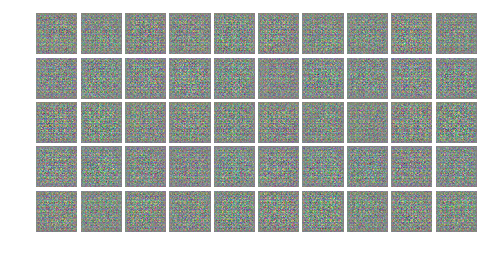


Number of Trainable parameters: 11251584


In [10]:
# Testing Gen dimensions:
inp_noise = torch.randn((batch_size, 100, 1, 1))
inp_noise = Variable(inp_noise.to(DEVICE))

y_rand = (torch.rand(batch_size, 1) * num_labels).type(torch.LongTensor).squeeze()
onehot = torch.zeros(num_labels, num_labels)
onehot = onehot.scatter_(1, torch.LongTensor([range(num_labels)]).view(num_labels,1), 1).view(num_labels, num_labels, 1, 1)
y_label = onehot[y_rand]
y_label = Variable(y_label.to(DEVICE))

G = Generator(ngf = ngf, num_classes=num_labels,batch_size=batch_size)
print(G)
Fake_images = G(inp_noise, y_label)

with torch.no_grad():
    fake_images = G(inp_noise, y_label)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(fake_images.to(DEVICE), padding=5,pad_value = 1, nrow = 10, normalize=True).cpu(),(1,2,0)))
plt.show()

print('\nNumber of Trainable parameters:',sum(p.numel() for p in G.parameters() if p.requires_grad))

In [ ]:
# Defining Gen,Disc, Optimizers, Schedulers and Losses

D = Discriminator(num_classes = num_labels,ndf=ndf,batch_size=batch_size).to(DEVICE)
G = Generator(num_classes=num_labels,ngf=ngf,batch_size=batch_size).to(DEVICE)

# Setup Adam optimizers for both G and D
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

#Schedulers if necessary
scheduler1 = torch.optim.lr_scheduler.StepLR(D_opt, step_size=50, gamma=0.5, last_epoch=-1) 
scheduler2 = torch.optim.lr_scheduler.StepLR(G_opt, step_size=50, gamma=0.5, last_epoch=-1)

dis_criterion = nn.BCELoss()
aux_criterion = nn.NLLLoss()

In [ ]:
# Initialize stuff before training
step = 0
n_noise = 100
path1 = F"/content/gdrive/My Drive/Colab Notebooks/ACGAN"  

In [20]:
# Toy function for plotting the gradient flows during the training:
def plot_grad_flow1(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

In [ ]:
G_losses = []
D_losses = []
img_list = []

real = 1 
fake = 0 

fixed_y = torch.zeros(num_labels, 1)
y_label = torch.zeros(batch_size, num_labels)

# Creates one-hot array, that is diagonal matrix in a tensor form of shape batch size x number of labels x 1 x 1
onehot = torch.zeros(num_labels, num_labels)
onehot = onehot.scatter_(1, torch.LongTensor([range(num_labels)]).view(num_labels,1), 1).view(num_labels, num_labels, 1, 1)


# Fixed Y labels for evaluation during training, has to be adjusted depending on number of classes 
y_0 = torch.full((batch_size//num_labels, 1), 0).type(torch.LongTensor).squeeze()
y_fixed_labels = torch.zeros(batch_size, num_labels)
for i in range(1,num_labels):
    desired_label = i
    y_fixed = torch.full((batch_size//num_labels, 1), desired_label).type(torch.LongTensor).squeeze()
    y_0 = torch.cat((y_0, y_fixed), 0)

y_fixed_labels = onehot[y_0]
y_fixed_labels= Variable(y_fixed_labels.to(DEVICE))

# Fixed noise for evaluating during training
fixed_noise = torch.randn((batch_size, 100, 1, 1))
fixed_noise = Variable(fixed_noise.to(DEVICE))

#Allocating labels
dis_label = torch.FloatTensor(batch_size).to(DEVICE)
aux_label = torch.LongTensor(batch_size).to(DEVICE)

for epoch in range(num_epochs):
    scheduler1.step()
    scheduler2.step()
    for idx, (images, labels) in enumerate(dataloader):

        # Training Discriminator with real data
        D.zero_grad()
        #dis_label.data.fill_(real)
        dis_label.data.uniform_(0.8,1) # Instead of using hard labels we use smoothed labels
        aux_label.data.copy_(labels)
        predictions_real, predictions_label = D(images.to(DEVICE)) # Making predictions on real images
        
        dis_errD_real = dis_criterion(predictions_real.squeeze(), dis_label)
        aux_errD_real = aux_criterion(predictions_label.squeeze(), aux_label)
        errD_real = dis_errD_real + aux_errD_real # loss for real images
        errD_real.backward()
        D_x = predictions_real.data.mean() # For computing statistics during training
        

        # Training Discriminator with fake data
        z = torch.randn((batch_size, 100, 1, 1))
        z = Variable(z.to(DEVICE))
        y_rand = (torch.rand(batch_size, 1) * num_labels).type(torch.LongTensor).squeeze()
        y_label = onehot[y_rand]
        y_label = Variable(y_label.to(DEVICE))
        
        fake_images = G(z,y_label) # Generating fake images
        aux_label.data.copy_(y_rand)
        #dis_label.data.fill_(fake)
        dis_label.data.uniform_(0,0.2) # Smoothed labels for discriminator
        predictions_fake, predictions_label = D(fake_images.detach()) # Making predictions on fake images
        
        dis_errD_fake = dis_criterion(predictions_fake.squeeze(), dis_label)
        aux_errD_fake = aux_criterion(predictions_label.squeeze(), aux_label)
        errD_fake = dis_errD_fake + aux_errD_fake # Loss for fake images, for discriminator training
        
        errD_fake.backward()
        D_G_z1 = predictions_fake.data.mean() # For computing statistics during training
        errD = errD_real + errD_fake
        D_opt.step()
        
        ###
        # Exp replay Not used in last implementations
        ###
        
        #r_idx = np.random.randint(batch_size)
        #exp_replay[abc] = fake_images[r_idx]
        #exp_labels[abc] = y_rand[r_idx]
        
        #if (abc+1) == batch_size:
        #  predictions_fake, predictions_label = D(exp_replay.detach())
        #  dis_label.data.fill_(fake)
        #  exp_label.data.copy_(exp_labels)
        # dis_errD_fake = dis_criterion(predictions_fake.squeeze(), dis_label)
        #  aux_errD_fake = aux_criterion(predictions_label.squeeze(), exp_label)
        #  exp_fake = 0.5*(dis_errD_fake + aux_errD_fake)
        #  exp_fake.backward()
        #  D_opt.step()
        #  abc = 0
        #else:
        #  D_opt.step()
        
        
        # Training Generator
        G.zero_grad()
        
        z = torch.randn((batch_size, 100, 1, 1)) # we generated new noise and labels
        z = Variable(z.to(DEVICE))
        y_rand = (torch.rand(batch_size, 1) * num_labels).type(torch.LongTensor).squeeze()
        y_label = onehot[y_rand]
        y_label = Variable(y_label.to(DEVICE))
        
        dis_label.data.fill_(real)  # fake labels are real for generator cost
        
        predictions_fake, predictions_label = D(fake_images) 
        dis_errG = dis_criterion(predictions_fake.squeeze(), dis_label)
        aux_errG = aux_criterion(predictions_label.squeeze(), aux_label)
        
        errG = dis_errG + aux_errG
        errG.backward()
        D_G_z2 = predictions_fake.data.mean()
        G_opt.step()
        
        
        if step % 100 == 0: # When statistics are printed + losses saved
            print('[%d/%d][%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, step,
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2)) # output training statistics
            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
        step += 1
        #abc +=1 # dummy index for expreplay
        
        if (epoch % 5 == 0): # Show generated images and other useful things about the training
            print("Figure number: ", epoch+1)

            G.eval()
            with torch.no_grad():
                fake_images = G(fixed_noise,y_fixed_labels).detach().cpu() # Images have to be generated without gradient !
            fig, axs = plt.subplots(ncols=3,figsize=(30,10))
            ax = axs[0]
            ax.axis("off")
            ax.set_title("Training Images") # Plotting the images
            ax.imshow(np.transpose(vutils.make_grid(fake_images.to(DEVICE), padding=5,pad_value = 1, nrow = 10, normalize=True).cpu(),(1,2,0)))
            ax = axs[1]
            
            ax.set_title("Generator and Discriminator Loss During Training") # Plotting the loss
            ax.plot(G_losses,label="G")
            ax.plot(D_losses,label="D")
            plt.xlabel("iterations")
            plt.ylabel("Loss")
            plt.legend()
            ax = axs[2]
            plot_grad_flow1(G.named_parameters()) # Plotting the gradient flow of the generator.
            plt.show()
            G.train()
            
        if (epoch % 5 == 0): # Save the images and the generator/discriminator at the current epoch.
            vutils.save_image((fake_images.data), os.path.join(path1, 'fake_images-{}.png'.format(epoch+1)), nrow = 10, normalize=True)
            torch.save(G.state_dict(), os.path.join(path1, 'G--{}.ckpt'.format(epoch+1)))
            torch.save(D.state_dict(), os.path.join(path1, 'D--{}.ckpt'.format(epoch+1)))
        
        
        

In [ ]:
# Train the losses during the training
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

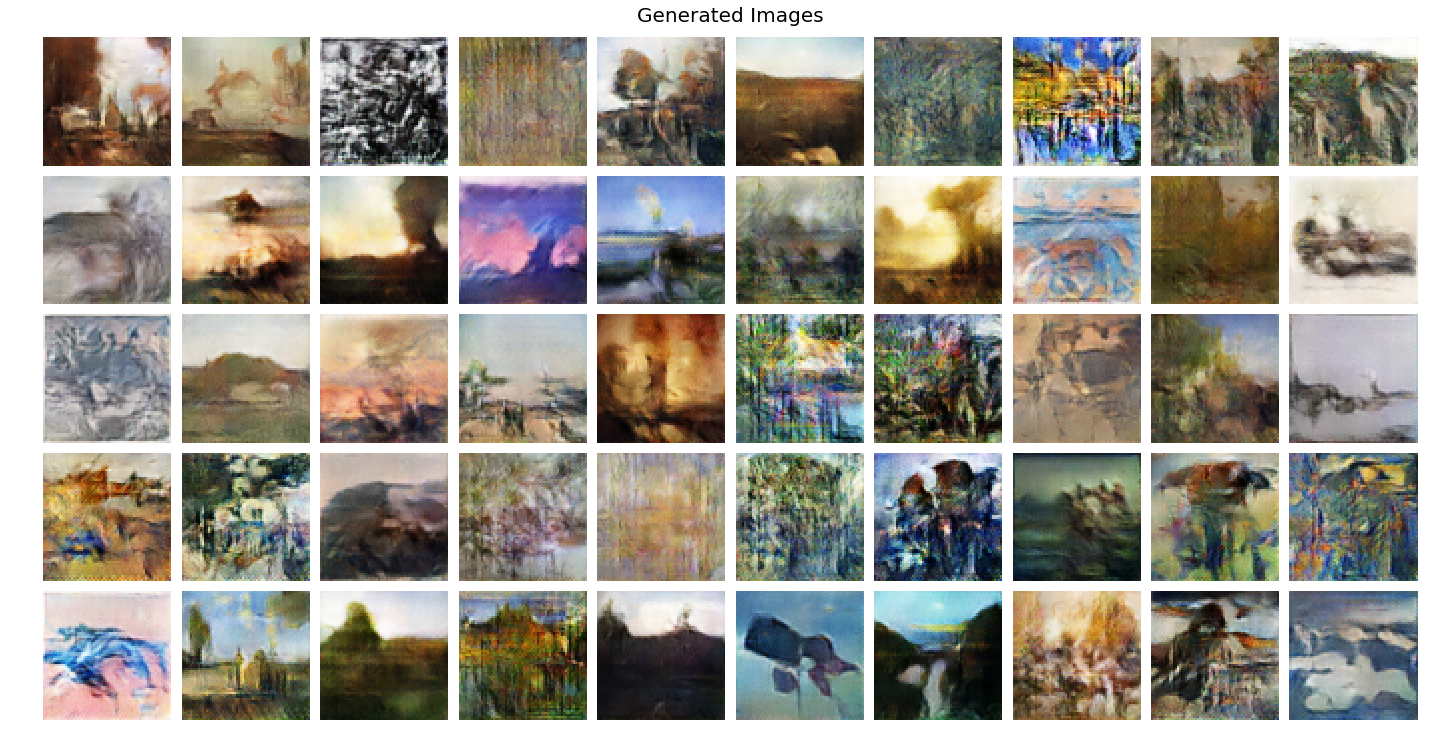

In [32]:
## Loading a model for testing/evaluation:

gen_filename = 'G--151.ckpt'
disc_filename = 'D--151.ckpt'

path1 = F"./{gen_filename}"
path2 = F"./{disc_filename}"

G = Generator(ngf=ngf,num_classes=num_labels,batch_size=batch_size).to(DEVICE)
G.load_state_dict(torch.load(path1,map_location='cpu'))

D = Discriminator(ndf=ndf,batch_size=batch_size,num_classes = num_labels).to(DEVICE)
D.load_state_dict(torch.load(path2,map_location='cpu'))

onehot = torch.zeros(num_labels, num_labels)
onehot = onehot.scatter_(1, torch.LongTensor([range(num_labels)]).view(num_labels,1), 1).view(num_labels, num_labels, 1, 1) 
batch_size = 50

G.eval()




z = torch.randn((batch_size, 100, 1, 1))
z = Variable(z.to(DEVICE))



for i in range(1):

    y_rand = torch.ones(batch_size,1).type(torch.LongTensor).squeeze() * 0 # specific label
    y_label = onehot[y_rand]
    y_label = Variable(y_label.to(DEVICE))




    with torch.no_grad():
        fake_images = G(z,y_label).detach().cpu()

    plt.figure(figsize=(25,25))
    plt.axis("off")
    plt.title("Generated Images",FontSize=20)
    plt.imshow(np.transpose(vutils.make_grid(fake_images.to(DEVICE), padding=5,pad_value = 1, nrow = 10, normalize=True).cpu(),(1,2,0)))
    plt.show()


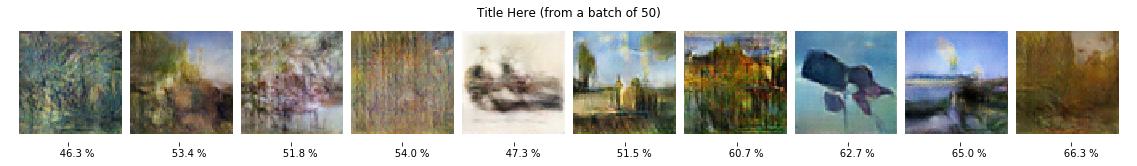

tensor([0, 0, 2, 0, 0, 0, 0, 2, 0, 0])


In [33]:
# Passing the images to discriminator:

with torch.no_grad():
    predictions_fake, predictions_label = D(fake_images)
indx = (max(predictions_fake) == predictions_fake)
ind = np.argmax(predictions_fake)
ind = np.argpartition(predictions_fake.numpy().squeeze(), -10)[-10:]

val = predictions_fake[ind].numpy()*100
    
plt.figure(figsize=(20,6))
plt.yticks([])
ticks = np.linspace(35,660,10)

labels = ["%10.1f %%" % val for val in val]
plt.xticks(ticks,labels)


plt.box(False)
im = np.transpose(vutils.make_grid(fake_images.to(DEVICE)[ind], padding=5,pad_value = 1, nrow = 10, normalize=True).cpu(),(1,2,0))
plt.title("Title Here (from a batch of 50)")
plt.imshow(im)

plt.show()


print(np.argmax(predictions_label[ind].exp(),axis=1))

In [70]:
k = 8
print(z[0].shape)
print(z[9][0:2].shape)

interpolations = np.linspace(z[0][:2].view(1,-1),z[9][:2].view(1,-1),num=k)
print(interpolations)

torch.Size([100, 1, 1])
torch.Size([2, 1, 1])


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

torch.Size([50, 100, 1, 1])


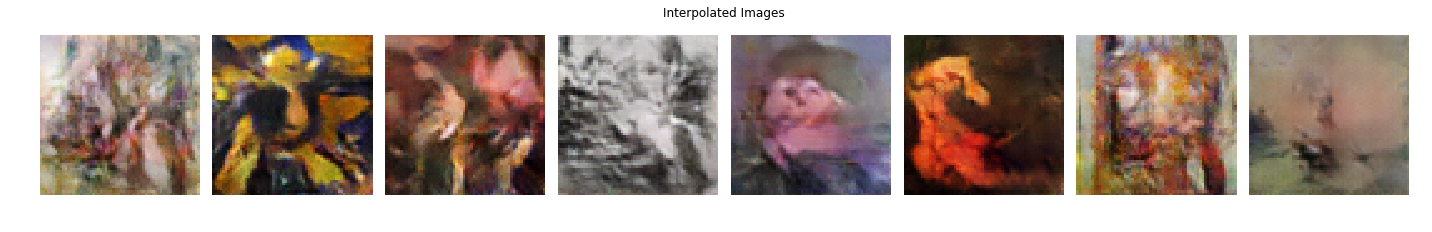

In [42]:
k = 8
print(z.shape)
interpolations = np.linspace(z[0].cpu().view(-1),z[9].cpu().view(-1),num=k)
new_noise = torch.tensor(c).to(DEVICE)
new_noise = new_noise.view(k,100,1,1).to(DEVICE)
new_label = torch.zeros(k,num_labels,1,1).to(DEVICE)
for i in range(k):
    #Manually setting the correct label for generated images
    new_label[i][0] = 0 
  
  



z = torch.randn((batch_size, 100, 1, 1))
z = Variable(z.to(DEVICE))
y_rand = (torch.rand(batch_size, 1) * num_labels).type(torch.LongTensor).squeeze()
y_rand = torch.ones(batch_size,1).type(torch.LongTensor).squeeze() * 0 # specific label
y_lab = onehot[y_rand]
y_lab = Variable(y_lab.to(DEVICE))

# Voisi taas tehdä järkevämmin, mutta pitäisi muokata generaattoria
y_lab[:k] = new_label
z[:k] = new_noise
G.eval()
with torch.no_grad():
    inter_images = G(z,y_lab).detach().cpu()
plt.figure(figsize=(25,25))
plt.axis("off")
plt.title("Interpolated Images")
plt.imshow(np.transpose(vutils.make_grid(inter_images.to(DEVICE)[:k], padding=5,pad_value = 1, nrow = 9, normalize=True).cpu(),(1,2,0)))
plt.show()

In [ ]:
import scipy.spatial.distance as scp
dataset = []
Kuva_nmro = 92
flatted = fake_images[Kuva_nmro].view(1,-1) # Tähän kuva mille etitään vastaavanlaista

N1 = 11 # Kuvien määrä siinä classissa mistä haetaan, pitää määritellä dataset uudestaan
N2 = 66 # Label2 66 kuvaa

for i in range(1,2):
    dataset.append(dset.ImageFolder(root=F"./Dog_images/Label{i}",
                           transform=transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])))

      
# Create labels for our dataset
# Labels are in i
for i in range(len(dataset)):
    for j in range(len(dataset[i])):
        dataset[i].samples[j] = (dataset[i].samples[j][0],i)
        
# Combine all the datasets
batch_s = N1 

newdataset = torch.utils.data.ConcatDataset(dataset)
dataloader = torch.utils.data.DataLoader(newdataset, batch_size=batch_s,
                                        shuffle=True, num_workers=workers)

print("Number of pictures in the dataset: ",len(dataloader.dataset))
real_batch = next(iter(dataloader))

images = real_batch[0] # Tähän kaikki datasetin kuvat


flat = torch.zeros(N1,3*64*64)
for i in range(N1):
    flat[i] = images[i].view(-1) # litistetään kuvat

#print(flat.shape)
#flatted = torch.cat([flatted,flat],0)
#print(flatted.shape)
dist1 = scp.cdist(flatted,flat,'cityblock') # Cityblock pitäisi olla L1 etäisyys

#Y = scp.squareform(scp.pdist(flatted,'cityblock')) 
#dist = scp.pdist(flatted,'cityblock')[0:N]
Ymin = np.min(dist1) # Etsitään pienin etäisyys (= samanlaisin kuva)
print(Ymin)
indx = np.where(dist1==Ymin) # Etsitään sen kuvan indeksi
print(np.where(dist1==Ymin)) 


#Y = scp.cdist(flatted,flat)
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(vutils.make_grid(fake_images.to(DEVICE)[Kuva_nmro],nrow=10, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(DEVICE)[indx[1]],nrow=10, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()